<a href="https://colab.research.google.com/github/dsklnr/Loan_Prediction/blob/main/LoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats
import pydotplus
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import dmba
from dmba import classificationSummary, gainsChart, liftChart, stepwise_selection, regressionSummary,plotDecisionTree
from dmba.metric import AIC_score

from google.colab import drive
from google.colab import files

from keras.models import Sequential
from keras.layers import Dense

## Data Preprocessing

Mount the google drive to the notebook so that we can upload files required for this project.

In [ ]:
# Allowing google colab to access drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Uploading dataset
uploaded = files.upload()

Saving loan_approval_dataset.csv to loan_approval_dataset (1).csv


Import the csv file for the loan prediction project.

In [ ]:
# Read the csv file
loan_df = pd.read_csv("/content/loan_approval_dataset.csv")
display(loan_df.shape)
loan_df.head()

(4269, 13)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


The dataset has extra spaces in column names and corresponding values. The extra spaces in column names and values should be removed. This will prevent issues later when performing data mining processes.

In [ ]:
# List all the column names in the DataFrame
print("\n Original Column Names:\n", list(loan_df.columns))

# Remove leading spaces from column names
loan_df.columns = loan_df.columns.str.strip()

# Print the new column names with extra spaces removed
print("\n New Column Names:\n", list(loan_df.columns), "\n")

# Remove leading spaces from values
loan_df = loan_df.applymap(lambda x: x.strip() if type(x) == str else x)


 Original Column Names:
 ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

 New Column Names:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status'] 



Get the information for each column (i.e. number of columns, column name, non-null count for each column, and the data type for each column).

In [ ]:
# Get the info from the DataFrame
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


Get the total number of null rows for each column to confirm there are no null values.

In [ ]:
# Get the total number of null values for each column
total_nulls = loan_df.isnull().sum()

# Sort the number of null values for each column in decsending order
total_nulls.sort_values(ascending=False)

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Ensure that each column's values are accurate according to the column type. For example, we should convert values if they are the wrong data type, make sure the values do not have spelling issues, etc. If issues are found with values, they should be corrected to refelect the accurate value.

Perform value analysis for number of dependents

In [ ]:
# Get all number of dependent values and the count for each level
num_of_dependents = loan_df['no_of_dependents'].value_counts()

# Sort the count of dependents in ascending order
num_of_dependents.sort_index(ascending=True)

0    712
1    697
2    708
3    727
4    752
5    673
Name: no_of_dependents, dtype: int64

Perform value analysis for level of education

In [ ]:
# Get all education values and the count for each
num_of_dependents = loan_df['education'].value_counts()

# Sort the count of education types in decsending order
num_of_dependents.sort_values(ascending=False)

Graduate        2144
Not Graduate    2125
Name: education, dtype: int64

Perform value analysis for self employment status

In [ ]:
# Get self employment status and the count for each
num_of_dependents = loan_df['self_employed'].value_counts()

# Sort the count of self employed in decsending order
num_of_dependents.sort_index(ascending=False)

Yes    2150
No     2119
Name: self_employed, dtype: int64

Perform value analysis for annual income

In [ ]:
# Get all annual income values and the count for each
num_of_dependents = loan_df['income_annum'].value_counts()

# Sort annual incomes in decsending order
num_of_dependents.sort_index(ascending=False)

9900000    35
9800000    48
9700000    40
9600000    39
9500000    40
           ..
600000     49
500000     46
400000     35
300000     51
200000     42
Name: income_annum, Length: 98, dtype: int64

Perform value analysis for loan amount

In [ ]:
# Get all loan amounts and the count for each
num_of_dependents = loan_df['loan_amount'].value_counts()

# Sort loan amounts types in decsending order
num_of_dependents.sort_index(ascending=False)

39500000     1
38800000     1
38700000     2
38500000     1
38400000     1
            ..
700000      15
600000      13
500000      16
400000       7
300000       6
Name: loan_amount, Length: 378, dtype: int64

Perform value analysis for loan term



In [ ]:
# Get all loan terms and the count for each
num_of_dependents = loan_df['loan_term'].value_counts()

# Sort the count of each loan term in decsending order
num_of_dependents.sort_values(ascending=False)

6     490
12    456
4     447
10    436
18    422
16    412
20    411
14    405
2     404
8     386
Name: loan_term, dtype: int64

Perform value analysis for cibil score

In [ ]:
# Get all cibil scores and the count for each
num_of_dependents = loan_df['cibil_score'].value_counts()

# Sort the count of each cibil score in decsending order
num_of_dependents.sort_values(ascending=False)

348    16
538    15
543    15
778    14
509    14
       ..
334     2
773     2
893     2
484     2
864     1
Name: cibil_score, Length: 601, dtype: int64

Perform value analysis for residential asset value

In [ ]:
# Get all residential asset values and the count for each
num_of_dependents = loan_df['residential_assets_value'].value_counts()

# Sort the count of residential asset values in decsending order
num_of_dependents.sort_values(ascending=False)

400000      66
500000      63
100000      60
1000000     57
600000      56
            ..
18900000     1
25000000     1
27400000     1
23100000     1
27300000     1
Name: residential_assets_value, Length: 278, dtype: int64

Perform value analysis for commercial asset value

In [ ]:
# Get all commercial asset values and the count for each
num_of_dependents = loan_df['commercial_assets_value'].value_counts()

# Sort the count of commercial assets values in decsending order
num_of_dependents.sort_values(ascending=False)

0           107
200000      101
100000      100
300000       90
500000       83
           ... 
19400000      1
18300000      1
17400000      1
15700000      1
18900000      1
Name: commercial_assets_value, Length: 188, dtype: int64

Perform value analysis for luxury asset value

In [ ]:
# Get all luxury asset values and the count for each
num_of_dependents = loan_df['luxury_assets_value'].value_counts()

# Sort the count of luxury asset values in decsending order
num_of_dependents.sort_values(ascending=False)

6200000     26
20400000    26
2900000     26
12300000    24
14900000    24
            ..
38000000     1
36200000     1
35000000     1
35300000     1
36700000     1
Name: luxury_assets_value, Length: 379, dtype: int64

Perform value analysis for bank asset value

In [ ]:
# Get all bank asset values and the count for each
num_of_dependents = loan_df['bank_asset_value'].value_counts()

# Sort the count of bank asset values in decsending order
num_of_dependents.sort_values(ascending=False)

1400000     63
3600000     63
4900000     63
4500000     61
1600000     60
            ..
14600000     2
14200000     2
14400000     1
14300000     1
13700000     1
Name: bank_asset_value, Length: 146, dtype: int64

Perform value analysis for loan status

In [ ]:
# Get all loan statuses and the count for each
num_of_dependents = loan_df['loan_status'].value_counts()

# Sort the count of loan statuses in decsending order
num_of_dependents.sort_values(ascending=False)

Approved    2656
Rejected    1613
Name: loan_status, dtype: int64

## Remove Outliers

Description:

> Create a function that removes outlier values based on +/- 1.5 times the inter quartile range from the first and third quartiles.



Parameters:

> Column name, DataFrame

Output:

> DataFrame with outliers removed from defined column



In [ ]:
# Create a function to remove outliers from one column in a dataframe based on iqr
def remove_outliers(column, dataframe):
  quartile1 = dataframe[column].quantile(0.25)
  quartile3 = dataframe[column].quantile(0.75)
  iqr = quartile3 - quartile1
  lower_bound = quartile1 - 1.5 * iqr
  upper_bound = quartile3 + 1.5 * iqr
  removed_outliers_df = dataframe[(dataframe[column] >= lower_bound)
          & (dataframe[column] <= upper_bound)]
  print(dataframe.shape)
  return removed_outliers_df

Use the function to remove rows with outliers in numerical columns. Print the new size of the DataFrame after removing outliers for each column.

In [ ]:
# Remove outliers from annual incomes, loan amounts, cibil scores,
# residential asset values, commercial asset values, luxury asset values, bank asset values
loan_df = remove_outliers("income_annum", loan_df)
loan_df = remove_outliers("loan_amount", loan_df)
loan_df = remove_outliers("cibil_score", loan_df)
loan_df = remove_outliers("residential_assets_value", loan_df)
loan_df = remove_outliers("commercial_assets_value", loan_df)
loan_df = remove_outliers("luxury_assets_value", loan_df)
loan_df = remove_outliers("bank_asset_value", loan_df)

(4269, 13)
(4269, 13)
(4269, 13)
(4269, 13)
(4217, 13)
(4182, 13)
(4182, 13)


## Exploratory Data Analysis

Each categorical column has a bar chart that illustrates the column's value compared to the count of each attribute in each bar. The bar is colored for loans approved (green) and loans denied (red). A box and whisker plot was created to illustrate the relationship between the column's value and the loan requester's loan amount.

Each numerical column has a histogram that illustrates the column's value(s) compared to the count of variables in each bin. There are two box and whisker plots for numerical values. One box plot for the rejected loan status and one plot for the approved loan status. These correspond to the column specified.

EDA for the number of dependents

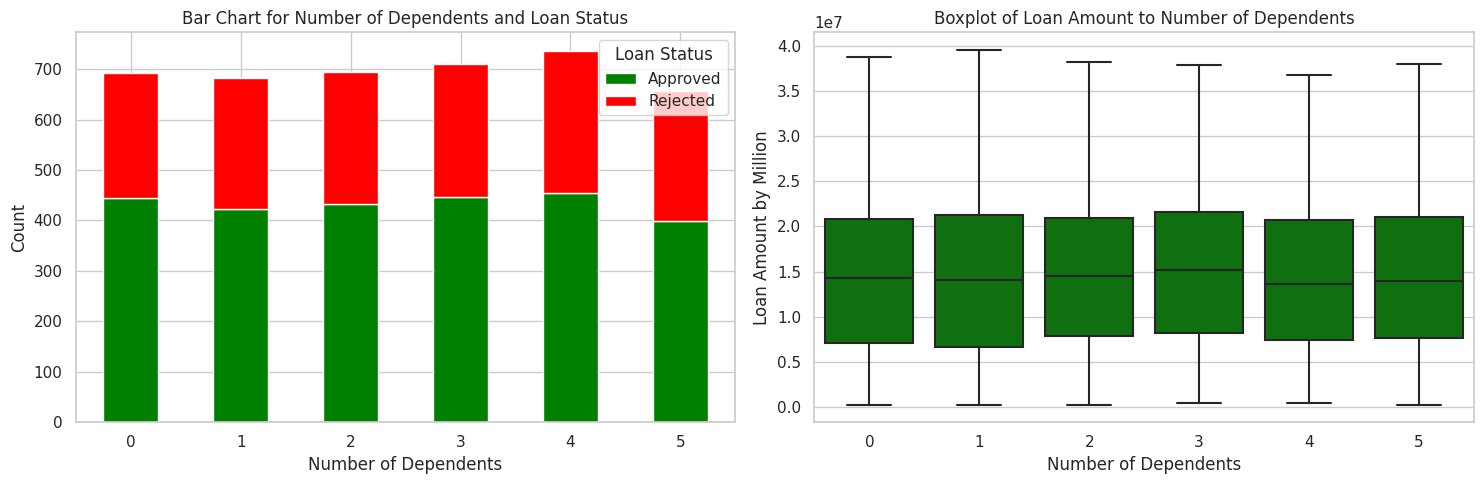

In [ ]:
# Create a crosstab for number of dependents and loan status
dependent_crosstab = pd.crosstab(loan_df["no_of_dependents"], loan_df["loan_status"])

# Create boxplots for loan amount considering number of dependents
sns.set(style="whitegrid")  # Set the style for the boxplots

# Create a 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first chart on the left side
dependent_crosstab.plot(kind="bar", stacked=True, color=["green", "red"], ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title="Loan Status")
axes[0].set_title("Bar Chart for Number of Dependents and Loan Status")
axes[0].set_xlabel("Number of Dependents")
axes[0].set_ylabel("Count")

# Plot the second chart on the right side

sns.boxplot(data=loan_df, x='no_of_dependents', y='loan_amount', color="green", ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].set_title("Boxplot of Loan Amount to Number of Dependents")
axes[1].set_xlabel("Number of Dependents")
axes[1].set_ylabel("Loan Amount by Million")

plt.tight_layout()  # Ensure the plots do not overlap
plt.show()

EDA for level of education

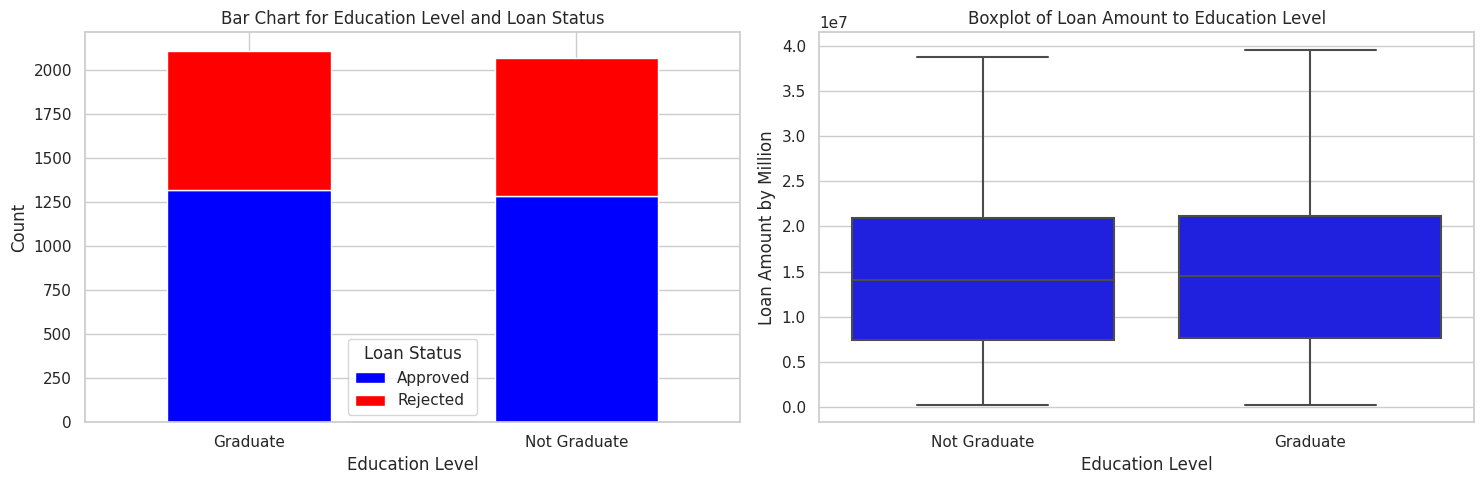

In [ ]:
# Create a crosstab for education level and loan status
education_crosstab = pd.crosstab(loan_df["education"], loan_df["loan_status"])

# Create boxplots for loan amount considering education level
sns.set(style="whitegrid")  # Set the style for the boxplots

# Create a 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first chart on the left side
education_crosstab.plot(kind="bar", stacked=True, color=["blue", "red"], ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title="Loan Status")
axes[0].set_title("Bar Chart for Education Level and Loan Status")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Count")

# Plot the second chart on the right side
sns.boxplot(data=loan_df, x='education', y='loan_amount', color="blue", ax=axes[1])
axes[1].set_title("Boxplot of Loan Amount to Education Level")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Loan Amount by Million")

plt.tight_layout()  # Ensure the plots do not overlap
plt.show()

EDA for self employment status

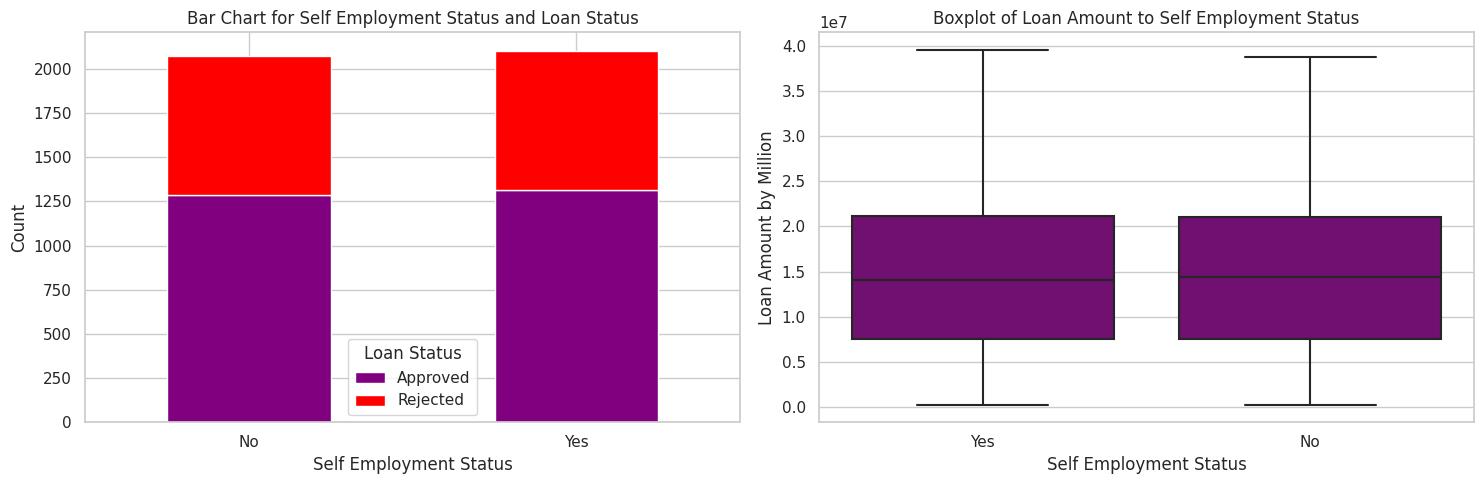

In [ ]:
# Create a crosstab for self-employment status and loan status
self_employment_crosstab = pd.crosstab(loan_df["self_employed"], loan_df["loan_status"])

# Create boxplots for loan amount considering self-employment status
# Create a 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first chart on the left side
self_employment_crosstab.plot(kind="bar", stacked=True, color=["purple", "red"], ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].legend(title="Loan Status")
axes[0].set_title("Bar Chart for Self Employment Status and Loan Status")
axes[0].set_xlabel("Self Employment Status")
axes[0].set_ylabel("Count")

# Plot the second chart on the right side
sns.boxplot(data=loan_df, x='self_employed', y='loan_amount', color="purple", ax=axes[1])
axes[1].set_title("Boxplot of Loan Amount to Self Employment Status")
axes[1].set_xlabel("Self Employment Status")
axes[1].set_ylabel("Loan Amount by Million")

plt.tight_layout()  # Ensure the plots do not overlap
plt.show()

EDA for requested loan amount

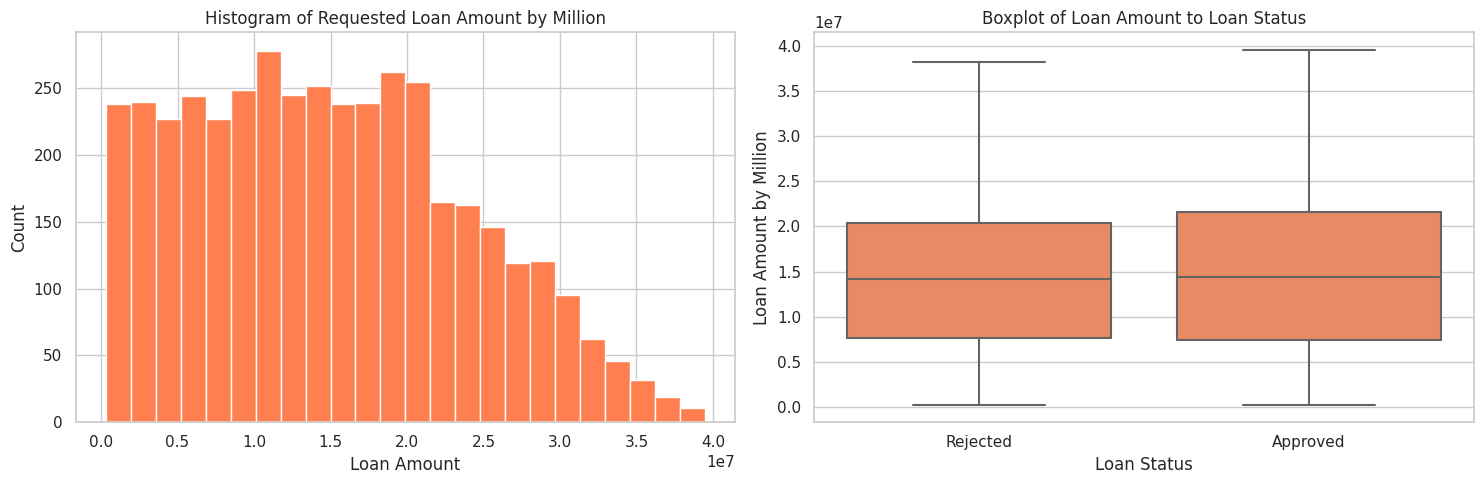

In [ ]:
# Create a histogram for requested loan amount
# Create a 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(data=loan_df, x="loan_amount", bins='auto', color="coral")
axes[0].set_title("Histogram of Requested Loan Amount by Million")
axes[0].set_xlabel("Loan Amount")
axes[0].set_ylabel("Count")

# Create boxplots for loan status considering loan amount
#plt.subplot(1, 3, 3)  # Create the third subplot

sns.boxplot(data=loan_df, x='loan_status', y='loan_amount', color="coral")
axes[1].set_title("Boxplot of Loan Amount to Loan Status")
axes[1].set_xlabel("Loan Status")
axes[1].set_ylabel("Loan Amount by Million")

plt.tight_layout()  # Ensure the plots do not overlap
plt.show()

EDA for annual income

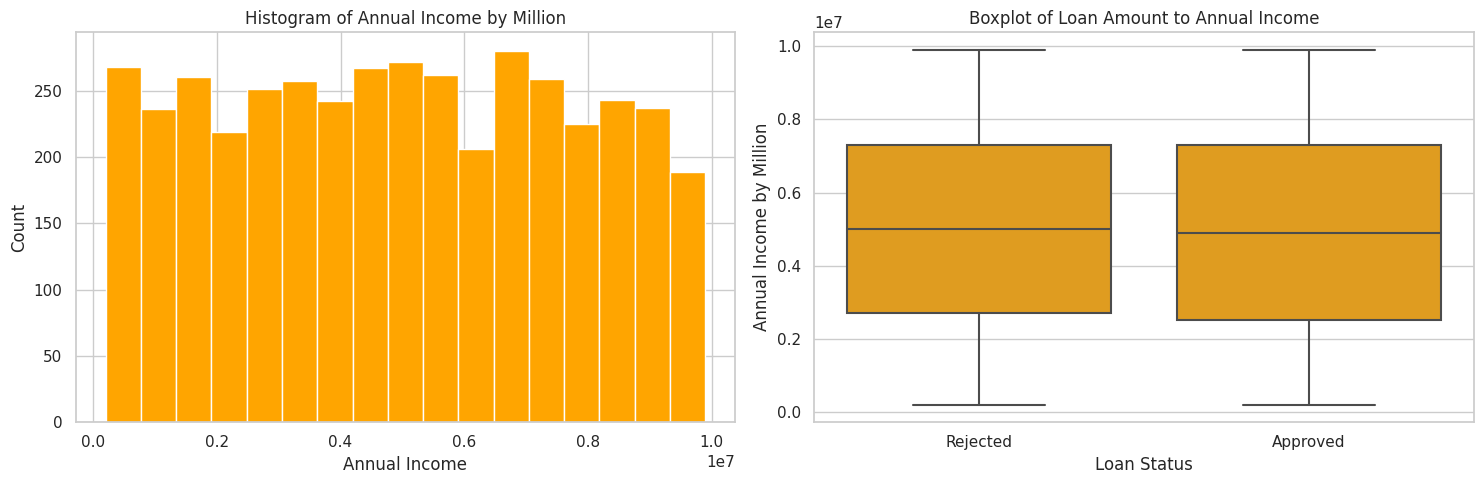

In [ ]:
# Create a 1x2 grid for the two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a histogram for annual income
axes[0].hist(data = loan_df, x = "income_annum", bins = 'auto', color = "orange")
axes[0].set_title("Histogram of Annual Income by Million")
axes[0].set_xlabel("Annual Income")
axes[0].set_ylabel("Count")

# Create boxplots for loan status considering annual income
sns.boxplot(data = loan_df, x = 'loan_status', y = 'income_annum', color = "orange")
axes[1].set_title("Boxplot of Loan Amount to Annual Income")
axes[1].set_xlabel("Loan Status")
axes[1].set_ylabel("Annual Income by Million")

plt.tight_layout()  # Ensure the plots do not overlap
plt.show()

EDA for loan term

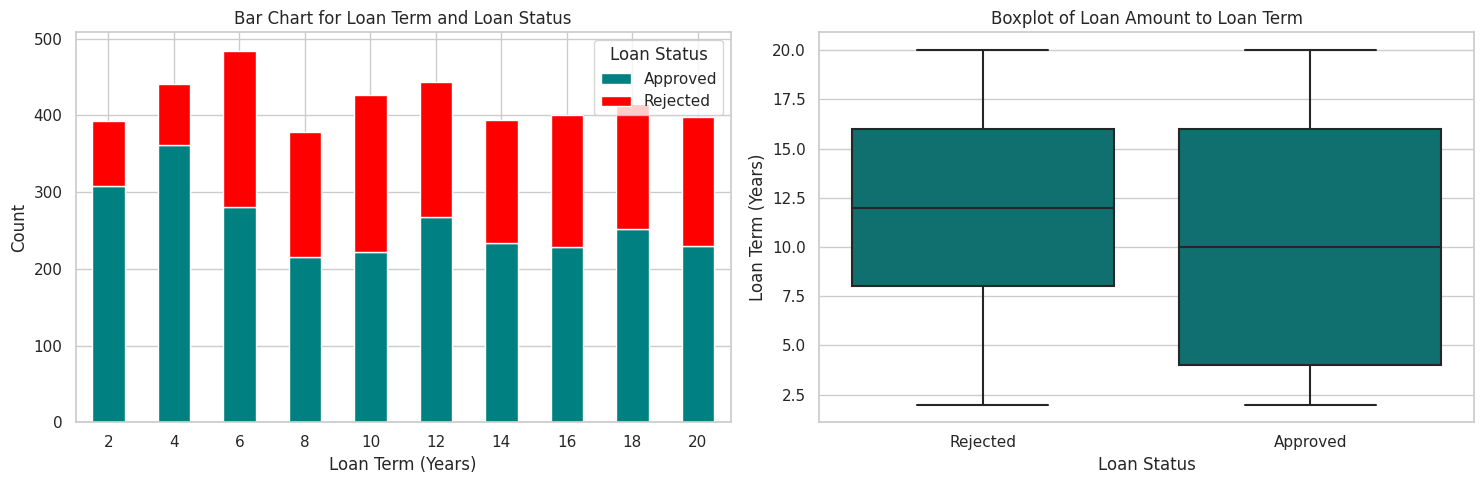

In [ ]:
# Create a crosstab for self-employment status and loan status
dependent_crosstab = pd.crosstab(loan_df["loan_term"], loan_df["loan_status"])

# Create a bar chart
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
dependent_crosstab.plot(kind="bar", stacked=True, color=["teal", "red"], ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=0)
axs[0].legend(title="Loan Status")
axs[0].set_title("Bar Chart for Loan Term and Loan Status")
axs[0].set_xlabel("Loan Term (Years)")
axs[0].set_ylabel("Count")

# Create boxplots for loan amount considering loan term
sns.boxplot(data=loan_df, x='loan_status', y='loan_term', color="teal", ax=axs[1])
axs[1].set_title("Boxplot of Loan Amount to Loan Term")
axs[1].set_xlabel("Loan Status")
axs[1].set_ylabel("Loan Term (Years)")

plt.tight_layout()
plt.show()

EDA for cibil score

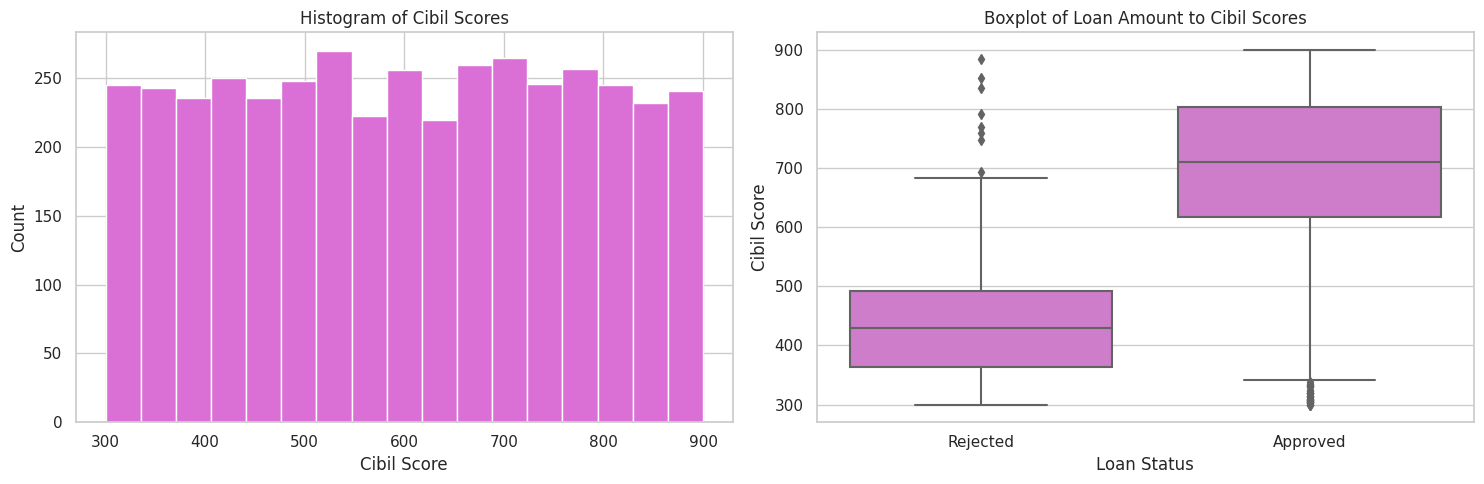

In [ ]:
# Create a histogram for Cibil scores
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(data=loan_df, x="cibil_score", bins='auto', color="orchid")
plt.title("Histogram of Cibil Scores")
plt.xlabel("Cibil Score")
plt.ylabel("Count")

# Create boxplots for loan status considering Cibil scores
plt.subplot(1, 2, 2)
sns.boxplot(data=loan_df, x='loan_status', y='cibil_score', color="orchid")
plt.title("Boxplot of Loan Amount to Cibil Scores")
plt.xlabel("Loan Status")
plt.ylabel("Cibil Score")

plt.tight_layout()
plt.show()

EDA for residential asset value

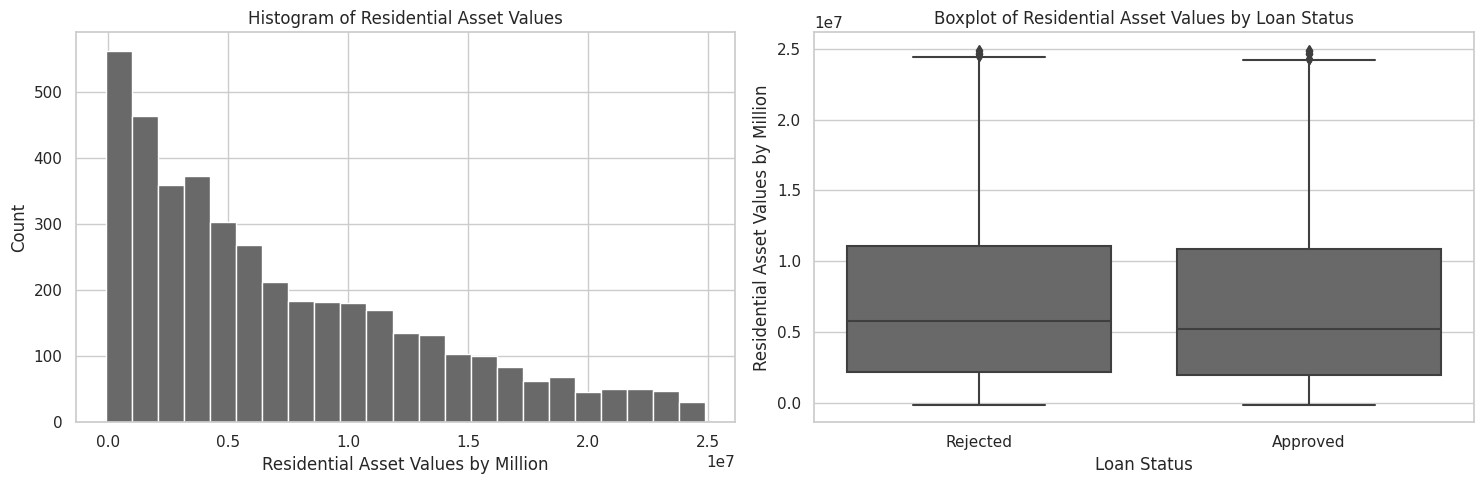

In [ ]:
# Create a histogram for residential asset values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(data=loan_df, x="residential_assets_value", bins='auto', color="dimgrey")
plt.title("Histogram of Residential Asset Values")
plt.xlabel("Residential Asset Values by Million")
plt.ylabel("Count")

# Create boxplots for loan status considering residential asset values
plt.subplot(1, 2, 2)
sns.boxplot(data=loan_df, x='loan_status', y='residential_assets_value', color="dimgrey")
plt.title("Boxplot of Residential Asset Values by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Residential Asset Values by Million")

plt.tight_layout()
plt.show()

EDA for commercial asset value

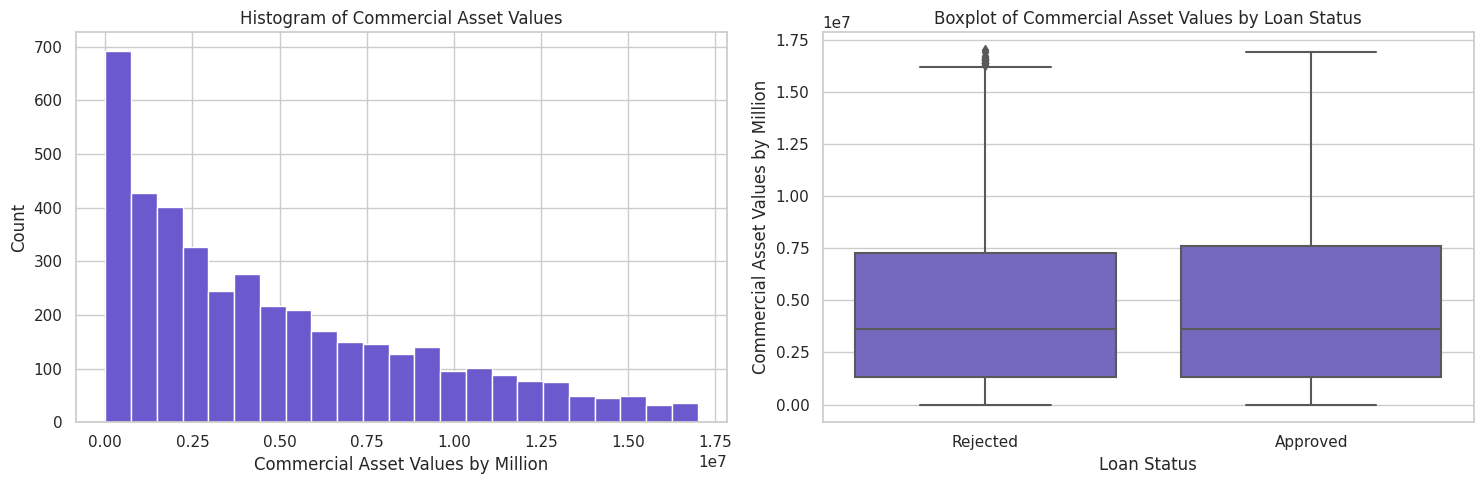

In [ ]:
# Create a histogram for commercial asset values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(data=loan_df, x="commercial_assets_value", bins="auto", color="slateblue")
plt.title("Histogram of Commercial Asset Values")
plt.xlabel("Commercial Asset Values by Million")
plt.ylabel("Count")

# Create boxplots for loan status considering commercial asset values
plt.subplot(1, 2, 2)
sns.boxplot(data=loan_df, x='loan_status', y='commercial_assets_value', color="slateblue")
plt.title("Boxplot of Commercial Asset Values by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Commercial Asset Values by Million")

plt.tight_layout()
plt.show()

EDA for luxury asset value

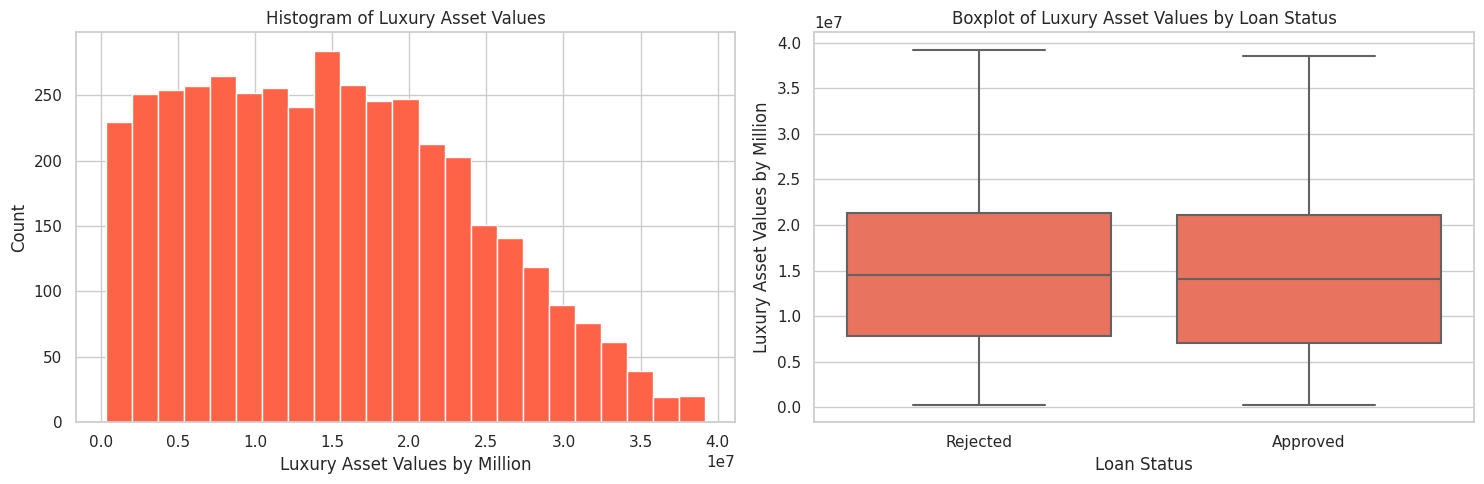

In [ ]:
# Create a histogram for luxury asset values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(data=loan_df, x="luxury_assets_value", bins="auto", color="tomato")
plt.title("Histogram of Luxury Asset Values")
plt.xlabel("Luxury Asset Values by Million")
plt.ylabel("Count")

# Create boxplots for loan status considering luxury asset values
plt.subplot(1, 2, 2)
sns.boxplot(data=loan_df, x='loan_status', y='luxury_assets_value', color="tomato")
plt.title("Boxplot of Luxury Asset Values by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Luxury Asset Values by Million")

plt.tight_layout()
plt.show()

EDA for bank asset value

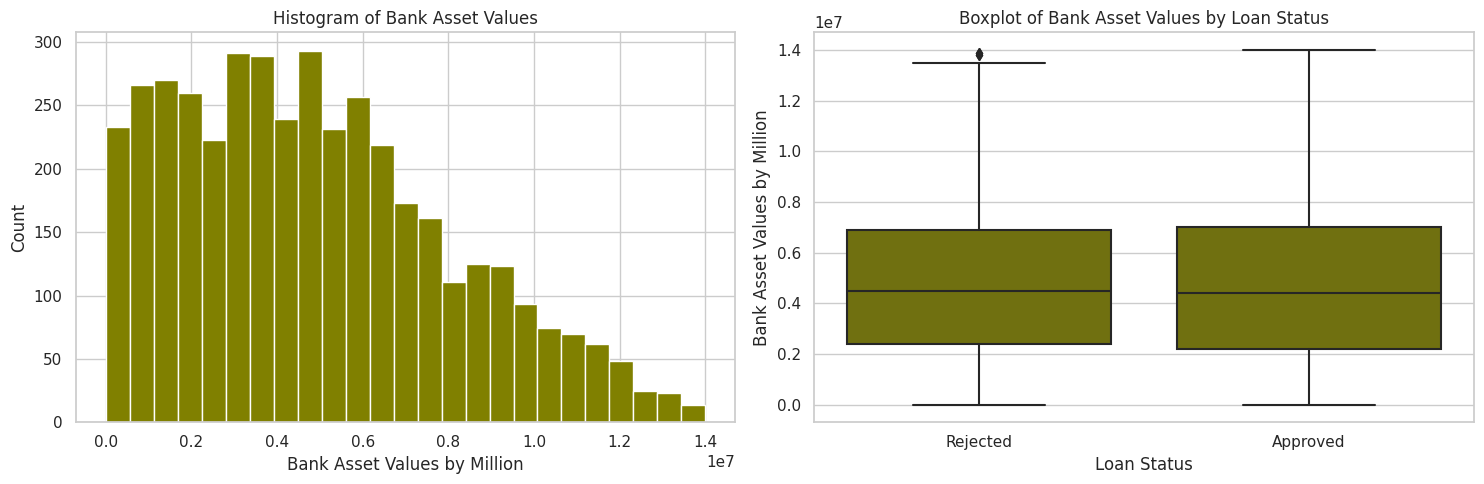

In [ ]:
# Create a histogram for bank asset values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(data=loan_df, x="bank_asset_value", bins="auto", color="olive")
plt.title("Histogram of Bank Asset Values")
plt.xlabel("Bank Asset Values by Million")
plt.ylabel("Count")

# Create boxplots for loan status considering bank asset values
plt.subplot(1, 2, 2)
sns.boxplot(data=loan_df, x='loan_status', y='bank_asset_value', color="olive")
plt.title("Boxplot of Bank Asset Values by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Bank Asset Values by Million")

plt.tight_layout()
plt.show()

# Correlation Matrix

Create a correlation matrix for numerical attributes. While these do not compare to load approval status, it could provide useful insights once we decide variables for our models.

In [ ]:
# Create a correlation matrix with each atttribute
loan_df.corr(method='pearson')

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
loan_id,1.000000,0.005884,0.013405,0.009556,0.005336,0.015991,0.023938,0.022695,0.001085,0.012257
no_of_dependents,0.005884,1.000000,0.008328,-0.005251,-0.020783,-0.010017,0.012032,-0.002042,0.003861,0.010527
income_annum,0.013405,0.008328,1.000000,0.927962,0.006938,-0.020922,0.627126,0.635076,0.929990,0.850779
loan_amount,0.009556,-0.005251,0.927962,1.000000,0.004848,-0.015739,0.591447,0.597812,0.863382,0.789859
loan_term,0.005336,-0.020783,0.006938,0.004848,1.000000,0.007863,0.002757,-0.011204,0.006588,0.013912
cibil_score,0.015991,-0.010017,-0.020922,-0.015739,0.007863,1.000000,-0.024220,0.005425,-0.025267,-0.017949
residential_assets_value,0.023938,0.012032,0.627126,0.591447,0.002757,-0.024220,1.000000,0.411741,0.586361,0.520692
commercial_assets_value,0.022695,-0.002042,0.635076,0.597812,-0.011204,0.005425,0.411741,1.000000,0.589048,0.548715
luxury_assets_value,0.001085,0.003861,0.929990,0.863382,0.006588,-0.025267,0.586361,0.589048,1.000000,0.788035
bank_asset_value,0.012257,0.010527,0.850779,0.789859,0.013912,-0.017949,0.520692,0.548715,0.788035,1.000000


# Chi-Squared Test for Categorical Attributes

Chi-squared tests are used to determine if there is statistical significance between categorical variables and a predictor variable (loan status). The strength of these relationships are shown as p-values. Lower p-values are better. For this test, p-values below a significance level of 0.05 are considered statistically significant.

In [ ]:
# Get the categorical columns
categorical_cols = ['education', 'self_employed', 'loan_term']
p_values = []

# Create contingency tables
for categorical_attr in categorical_cols:
    contingency_table = pd.crosstab(loan_df[categorical_attr], loan_df['loan_status'])

    # Get p-values from the contingency table
    chi2, p, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)
    p_values.append(p)

# Print the p-values for the categorical variables
p_values

[0.8054748482812306, 0.8808544370188185, 7.685890181657574e-29]

In [ ]:
# Set the significance level
alpha = 0.05

# Get the Bonferroni-corrected significance level
adjusted_alpha = alpha / len(categorical_cols)

# Get attributes with a significance level less than 0.05
significant_attributes = [(categorical_attr, p) for categorical_attr, p in zip(categorical_cols, p_values) if p < adjusted_alpha]

# Print the statistically significant categorical values
print("Statistically Significant Attributes:")
for attribute, p_val in significant_attributes:
  print(f"{attribute}'s p-value = {p_val}")

Statistically Significant Attributes:
loan_term's p-value = 7.685890181657574e-29


# T-Test for Numerical Attributes

Similar to chi-squared tests, t-tests determine if there is statistical significance between numerical variables and a predictor variable (loan status). The strength of these relationships are shown as p-values. Lower p-values are better. For this test, p-values below a significance level of 0.05 are considered statistically significant.

In [ ]:
# Get the numerical values
numerical_vals = ["no_of_dependents", "income_annum", "loan_amount", "loan_term", "cibil_score",
                  "residential_assets_value", "commercial_assets_value", "luxury_assets_value", "bank_asset_value"]

p_vals = {}

# iterate through numeric columns and find statistical significance
for attribute in numerical_vals:
  uncanceled = loan_df[loan_df['loan_status'] == 0][attribute]
  canceled = loan_df[loan_df['loan_status'] == 1][attribute]

  # Perfrom a t-test for the numerical column
  t_stat, p_val = stats.ttest_ind(uncanceled, canceled)
  if p_val < alpha:
    p_vals[attribute] = p_val
    print(f"{attribute}'s p-value is: {p_val}")

# Edge case for no statistically significant p-values from the t-test
if not p_vals:
  print("No statistically significant p-values according to the t-test")

No statistically significant p-values according to the t-test


# One-Way ANOVA for Numerical Attributes

Similar to t-tests, one-way ANOVA tests determine if there is statistical significance between numerical variables and a predictor variable (loan status). However, one-way ANOVA tests determine if three or more attributes are statistically different from one another. T-tests only determine if two attributes are statistically different from one another. Lower p-values are better. For this test, p-values below a significance level of 0.05 are considered statistically significant.

In [ ]:
# Create an empty list to store results
anova_results = []

# iterate through numeric columns and find statistical significance
for attribute in numerical_vals:
  uncanceled = loan_df[loan_df['loan_status'] == 0][attribute]
  canceled = loan_df[loan_df['loan_status'] == 1][attribute]

  # Perform one-way ANOVA
  f_statistic, p_val = stats.f_oneway(uncanceled, canceled)

  # Determine statistical significance
  if p_val < alpha:
    print(f"{attribute}'s p-value is: {p_val}")

# Edge case for no statistically significant p-values from one-way ANOVA
if not anova_results:
  print("No statistically significant p-values according to the one-way ANOVA test")

No statistically significant p-values according to the one-way ANOVA test


## Modeling

Convert binary columns to 0s and 1s

In [ ]:
# Get the values for the education and self employment columns
display(loan_df['education'].value_counts())
display(loan_df['self_employed'].value_counts())

Graduate        2106
Not Graduate    2067
Name: education, dtype: int64

Yes    2102
No     2071
Name: self_employed, dtype: int64

In [ ]:
# Replace values in the 'education' column
loan_df['education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace=True)
# Replace values in the 'self_employed' column
loan_df['self_employed'].replace({'Yes': 1, 'No': 0}, inplace=True)
# Replace values in the 'loan_status' column
loan_df['loan_status'].replace({'Approved': 1, 'Rejected': 0}, inplace=True)

In [ ]:
# Print the new values for each column
display(loan_df['education'].value_counts())
display(loan_df['self_employed'].value_counts())
display(loan_df['loan_status'].value_counts())

1    2106
0    2067
Name: education, dtype: int64

1    2102
0    2071
Name: self_employed, dtype: int64

1    2599
0    1574
Name: loan_status, dtype: int64

In [ ]:
# drop loan_id from the table
loan_df = loan_df.drop(['loan_id'], axis=1)
display(loan_df.head())

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0
5,0,1,1,4800000,13500000,10,319,6800000,8300000,13700000,5100000,0


In [ ]:
# Get the size of the DataFrame
print("Number of rows and columns:", loan_df.shape, "\n")

# Get the info from the loan DataFrame
print(loan_df.info())

Number of rows and columns: (4173, 12) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4173 entries, 1 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   no_of_dependents          4173 non-null   int64
 1   education                 4173 non-null   int64
 2   self_employed             4173 non-null   int64
 3   income_annum              4173 non-null   int64
 4   loan_amount               4173 non-null   int64
 5   loan_term                 4173 non-null   int64
 6   cibil_score               4173 non-null   int64
 7   residential_assets_value  4173 non-null   int64
 8   commercial_assets_value   4173 non-null   int64
 9   luxury_assets_value       4173 non-null   int64
 10  bank_asset_value          4173 non-null   int64
 11  loan_status               4173 non-null   int64
dtypes: int64(12)
memory usage: 423.8 KB
None


In [ ]:
# Check the zero variance variables
# Get a list of column names

columns = loan_df.columns

# Initialize a list to store columns with zero variance
zero_variance_columns = []

# Iterate through the columns and check for zero variance
for column in columns:
    std_deviation = loan_df[column].std()
    if std_deviation == 0:
        zero_variance_columns.append(column)

# Print the columns with zero variance
if zero_variance_columns:
    print("Columns with zero variance:", zero_variance_columns)
else:
    print("No columns have zero variance")

No columns have zero variance


In [ ]:
# create X and y for features and labels
y = loan_df['loan_status']
X = loan_df.drop('loan_status', axis=1)

# split the data into a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

print("Number of rows and columns for X_train:", X_train.shape)
print("Number of rows and columns for y_train:", y_train.shape)
print("Number of rows and columns for X_test:", X_test.shape)
print("Number of rows and columns for y_test:", y_test.shape)

Number of rows and columns for X_train: (2921, 11)
Number of rows and columns for y_train: (2921,)
Number of rows and columns for X_test: (1252, 11)
Number of rows and columns for y_test: (1252,)


In [ ]:
# list of binary column names to not scale
binary_columns = ['education', 'self_employed']

# seperate the binary and non-binary columns
X_train_non_binary = X_train.drop(columns=binary_columns)
X_test_non_binary = X_test.drop(columns=binary_columns)
X_train_non_binary

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
624,5,700000,2100000,14,863,100000,1200000,2700000,600000
2383,1,2800000,5900000,20,728,1000000,3200000,10300000,1400000
4194,5,2100000,4900000,12,651,2500000,2100000,6100000,1800000
2329,4,9000000,30400000,20,532,21000000,7400000,30500000,13100000
2937,1,2200000,5400000,16,641,5900000,0,4800000,1200000
...,...,...,...,...,...,...,...,...,...
3520,3,6900000,22700000,4,650,900000,13400000,15500000,6400000
478,3,3600000,8600000,8,790,5400000,5900000,9800000,5200000
3162,1,9400000,21000000,12,443,14100000,2700000,23200000,5600000
3854,0,3100000,8500000,8,614,1700000,4600000,11000000,3300000


In [ ]:
scaler = StandardScaler()

# fit the scaler with training data excluding binary columns and transform both train and test data
X_train_non_binary_scaled = scaler.fit_transform(X_train_non_binary)
X_test_non_binary_scaled = scaler.transform(X_test_non_binary)
X_train_non_binary_scaled

array([[ 1.47617493, -1.5413069 , -1.42328299, ..., -0.86176382,
        -1.35138897, -1.33820762],
       [-0.8842504 , -0.77684111, -0.99486305, ..., -0.38764561,
        -0.49693776, -1.08508327],
       [ 1.47617493, -1.03166304, -1.10760514, ..., -0.64841063,
        -0.96913448, -0.95852109],
       ...,
       [-0.8842504 ,  1.62576565,  0.70754248, ..., -0.50617516,
         0.95338074,  0.24381958],
       [-1.47435673, -0.66763171, -0.70173362, ..., -0.05576286,
        -0.41823831, -0.48391293],
       [-0.8842504 ,  0.09683408, -0.39732998, ...,  0.65541446,
         0.45869846, -0.67375619]])

In [ ]:
# add back the binary columns to the scaled data
X_train_scaled = np.concatenate([X_train_non_binary_scaled, X_train[binary_columns].values], axis=1)
X_test_scaled = np.concatenate([X_test_non_binary_scaled, X_test[binary_columns].values], axis=1)

# check the first 5 rows of the scaled training data
print(X_train_scaled[:5])

[[ 1.47617493 -1.5413069  -1.42328299  0.53916418  1.53241643 -1.14486106
  -0.86176382 -1.35138897 -1.33820762  1.          1.        ]
 [-0.8842504  -0.77684111 -0.99486305  1.58468215  0.74696201 -0.99923365
  -0.38764561 -0.49693776 -1.08508327  0.          1.        ]
 [ 1.47617493 -1.03166304 -1.10760514  0.19065819  0.29896208 -0.75652131
  -0.64841063 -0.96913448 -0.95852109  0.          1.        ]
 [ 0.8860686   1.48015312  1.76731812  1.58468215 -0.39340145  2.23693087
   0.60800264  1.77410361  2.61686039  1.          1.        ]
 [-0.8842504  -0.99525991 -1.0512341   0.88767017  0.24078027 -0.20637335
  -1.14623475 -1.11529061 -1.14836436  0.          1.        ]]


In [ ]:
# The loan_status is the response variable; we will change it to the category.
#loan_df['loan_status'] = loan_df['loan_status'].astype('category')

In [ ]:
# Split the dataset into training and validation sets
#train, valid = train_test_split(loan_df, train_size=0.7, random_state=1)
#print('Training   : ', train.shape)
#print('Validation : ', valid.shape)

In [ ]:
# Create a StandardScaler instance
#scaler = StandardScaler()

#continuous_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
                   #'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                   #'luxury_assets_value', 'bank_asset_value']

# Fit and transform the training data
#train[continuous_cols] = scaler.fit_transform(train[continuous_cols])

# Transform the full dataset (including validation and test data)
#Norm_loan_df = pd.DataFrame(scaler.transform(loan_df[continuous_cols]), columns=continuous_cols, index=loan_df.index)

# Concatenate the scaled continuous columns with the original DataFrame
#Norm_loan_df = pd.concat([Norm_loan_df, loan_df.drop(continuous_cols, axis=1)], axis=1)

# Split the data into trainNorm and validNorm
#trainNorm = Norm_loan_df.loc[train.index]
#validNorm = Norm_loan_df.loc[valid.index]

#print('trainNorm   : ', trainNorm.shape)
#print('validNorm : ', validNorm.shape)

In [ ]:
# Get the info from the train DataFrame
#trainNorm.info()

In [ ]:
#train_X = trainNorm.drop(columns='loan_status')
#train_y = trainNorm['loan_status']

#valid_X = validNorm.drop(columns='loan_status')
#valid_y = validNorm['loan_status']

## Logistic Regression

In [ ]:
logit = LogisticRegressionCV(penalty="l2", solver='liblinear')
logit.fit(X_train_scaled, y_train)

print('Regularization:', 1.0 / logit.C_[0])  # Inverse of the regularization parameter
print('Intercept:', logit.intercept_[0])

coefficients = pd.DataFrame({'coeff': logit.coef_[0]}, index=X_train.columns).transpose()
display(coefficients)


# Compute AIC score
aic = AIC_score(y_test, logit.predict(X_test_scaled), df=len(X_test.columns) + 1)
print('AIC:', aic)

Regularization: 166.81005372000593
Intercept: 0.4494626262814011


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
coeff,-0.05056,-0.069935,0.110107,-0.258184,1.585369,-0.072122,0.045126,-0.018261,-0.011866,0.17807,0.184274


AIC: 487.76089829443345


In [ ]:
# Confusion matrix
print('Training Confusion Matrix:\n')
classificationSummary(y_train, logit.predict(X_train_scaled))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(y_test, logit.predict(X_test_scaled))

Training Confusion Matrix:

Confusion Matrix (Accuracy 0.9281)

       Prediction
Actual    0    1
     0  997   94
     1  116 1714


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9153)

       Prediction
Actual   0   1
     0 432  51
     1  55 714


In [ ]:
valid_predictions = logit.predict(X_test_scaled)
accuracy = accuracy_score(y_test, valid_predictions)
precision = precision_score(y_test, valid_predictions)
recall = recall_score(y_test, valid_predictions)
f1 = f1_score(y_test, valid_predictions)

# Print the metrics
print('Logistic Regression:\n')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Logistic Regression:

Accuracy: 0.9153354632587859
Precision: 0.9333333333333333
Recall: 0.9284785435630689
F1-score: 0.9308996088657105


cibil_score indicates that this feature has a strong positive impact on the likelihood of loan approval, while loan_term has a negative impact.

Accuracy: The percentage of correct predictions made by the model. This model correctly predicts the outcome about 91.53% of the time.

Precision: The proportion of true positive predictions out of all positive predictions made by the model. In this validation set, it is about 93.33%.

Recall: The proportion of true positive predictions out of all actual positives. In this validation set, it's about 92.85%.

F1-score: A balance between precision and recall. In this validation set, it's approximately 93.09%.

Logistic Regression model shows good performance with high accuracy, precision, recall, and F1-score on the validation data. It seems to be effectively predicting loan approval.

## KNN

accuracy by k


,k,accuracy
0,1,0.870607
1,2,0.873003
2,3,0.893770
3,4,0.899361
4,5,0.907348
5,6,0.910543
6,7,0.909744
7,8,0.915335
8,9,0.908147
9,10,0.914537


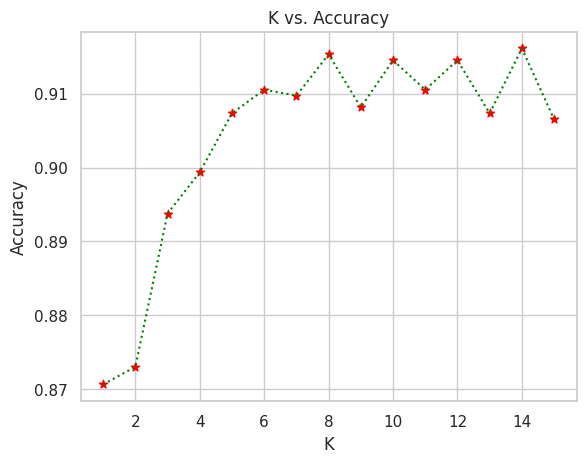

In [ ]:
# Train a classifier for different values of k
results = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test_scaled))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print('accuracy by k')
display(results)

# show accuracy by k
plt.plot(results.k, results.accuracy, linestyle=':', c='green')
plt.title('K vs. Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')

noteworthy_points = results[results['accuracy'] >= .8]
plt.scatter(noteworthy_points.k, noteworthy_points.accuracy, c='red', marker='*')

plt.show()

In [ ]:
# using k=11 to re train the knn model
knn = KNeighborsClassifier(n_neighbors=12).fit(X_train_scaled, y_train)

# Classification Matrix
print('Training Confusion Matrix:\n')
classificationSummary(y_train, knn.predict(X_train_scaled))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(y_test, knn.predict(X_test_scaled))

print('\nAIC', AIC_score(y_test, knn.predict(X_test_scaled), df=len(X_train.columns) + 1), '\n')

Training Confusion Matrix:

Confusion Matrix (Accuracy 0.9370)

       Prediction
Actual    0    1
     0 1018   73
     1  111 1719


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9145)

       Prediction
Actual   0   1
     0 442  41
     1  66 703

AIC 499.5168532124321 



In [ ]:
knn_valid_predictions = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_valid_predictions)
knn_precision = precision_score(y_test, knn_valid_predictions)
knn_recall = recall_score(y_test, knn_valid_predictions)
knn_f1 = f1_score(y_test, knn_valid_predictions)

# Print the metrics
print('KNN:\n')
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1-score:", knn_f1)

KNN:

Accuracy: 0.9145367412140575
Precision: 0.9448924731182796
Recall: 0.9141742522756827
F1-score: 0.9292795769993392


The KNN model achieves high accuracy, precision, recall, and F1-score, when k is set to 14. This suggests that considering 14 nearest neighbors provides the best trade-off between bias and variance in our model.

The AIC value provides additional information on model fit, and a lower AIC is generally preferable, indicating a slightly worse fit. In this case, the AIC is 499.5168532124321.

## Gradient Boosting

In [ ]:
# GBM Model
boost = GradientBoostingClassifier()
boost.fit(X_train_scaled, y_train)

# Classification Matrix
print('Training Confusion Matrix:\n')
classificationSummary(y_train, boost.predict(X_train_scaled))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(y_test, boost.predict(X_test_scaled))

print('\nAIC', AIC_score(y_test, boost.predict(X_test_scaled), df=len(X_test.columns) + 1), '\n')

Training Confusion Matrix:

Confusion Matrix (Accuracy 0.9962)

       Prediction
Actual    0    1
     0 1084    7
     1    4 1826


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9760)

       Prediction
Actual   0   1
     0 471  12
     1  18 751

AIC -1092.5657256928566 



In [ ]:
gbm_valid_predictions = boost.predict(X_test_scaled)
gbm_accuracy = accuracy_score(y_test, gbm_valid_predictions)
gbm_precision = precision_score(y_test, gbm_valid_predictions)
gbm_recall = recall_score(y_test, gbm_valid_predictions)
gbm_f1 = f1_score(y_test, gbm_valid_predictions)

# Print the metrics
print('GBM:\n')
print("Accuracy:", gbm_accuracy)
print("Precision:", gbm_precision)
print("Recall:", gbm_recall)
print("F1-score:", gbm_f1)

GBM:

Accuracy: 0.9760383386581469
Precision: 0.9842726081258192
Recall: 0.976592977893368
F1-score: 0.9804177545691907


Gradient Boosting model shows exceptional performance, especially in terms of training accuracy. While there's a slight drop in accuracy on the validation data, it still maintains a high level of performance, indicating the model's ability to generalize well to unseen data.

## Decision Tree

Initial parameters:  {'max_depth': 25, 'min_impurity_decrease': 0, 'min_samples_split': 40}
Improved parameters:  {'max_depth': 15, 'min_impurity_decrease': 0.001, 'min_samples_split': 8}


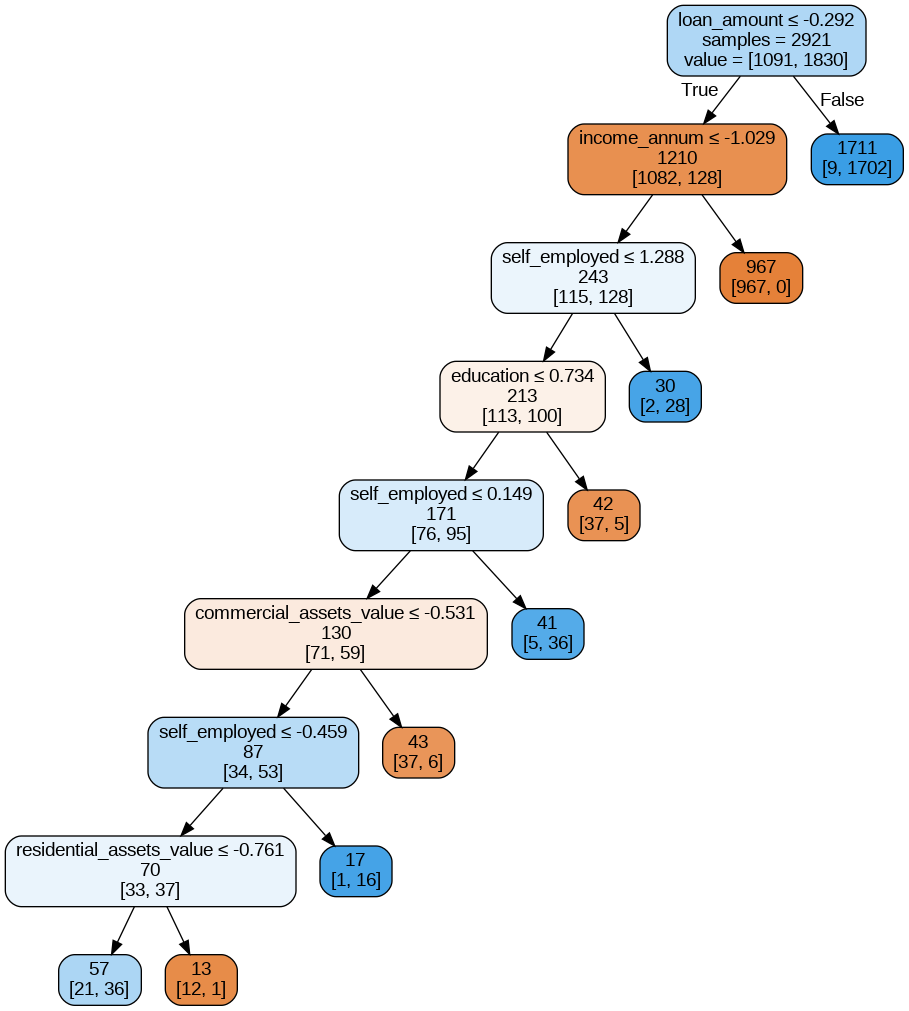

In [ ]:
# user grid search to find optimized tree
param_grid = {
                'max_depth': [5, 10, 15, 20, 25],
                'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008],
                'min_samples_split': [5, 10, 20, 30, 40, 50],
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train_scaled, y_train)
print('Initial parameters: ', gridSearch.best_params_)

# use first grid search to find more optimal hyperparamters.
param_grid = {
                'max_depth': [15, 18, 20, 22, 25],
                'min_impurity_decrease': [0, 0.0005, 0.001, 0.0015, 0.002],
                'min_samples_split': [8, 9, 10, 11, 12],
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train_scaled, y_train)

print('Improved parameters: ', gridSearch.best_params_)

plotDecisionTree(gridSearch.best_estimator_, feature_names=X_train.columns)

In [ ]:
# Confusion matrix
print('Training Confusion Matrix:\n')
classificationSummary(y_train, gridSearch.best_estimator_.predict(X_train_scaled))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(y_test, gridSearch.best_estimator_.predict(X_test_scaled))

print('\nAIC', AIC_score(y_test, gridSearch.predict(X_test_scaled), df=len(X_train.columns) + 1), '\n')

Training Confusion Matrix:

Confusion Matrix (Accuracy 0.9829)

       Prediction
Actual    0    1
     0 1053   38
     1   12 1818


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9744)

       Prediction
Actual   0   1
     0 465  18
     1  14 755

AIC -1011.7634972286164 



In [ ]:
best_decision_tree = gridSearch.best_estimator_
decision_tree_valid_predictions = best_decision_tree.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, decision_tree_valid_predictions)
dt_precision = precision_score(y_test, decision_tree_valid_predictions)
dt_recall = recall_score(y_test, decision_tree_valid_predictions)
dt_f1 = f1_score(y_test, decision_tree_valid_predictions)

# Print the metrics
print('Decision Tree:\n')
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)

Decision Tree:

Accuracy: 0.9744408945686901
Precision: 0.9767141009055628
Recall: 0.9817945383615084
F1-score: 0.9792477302204928


"The Decision Tree model, especially with the improved parameters, demonstrates outstanding performance. It exhibits high accuracy, precision, recall, and F1-score on both the training and test sets. The lower AIC value suggests a better model fit.

One notable feature of Decision Trees is their interpretability and ease of understanding, making them a valuable choice for decision support. In this particular case, the decision tree employs the 'cibil_score' as the primary node for splitting. If 'cibil_score' is less than or equal to 0.2999, the model continues to the 'loan' node.

## Random Forest

In [ ]:
# create a random forest classifier
forest_model = RandomForestClassifier()

# train model with features and labels
forest_model.fit(X_train_scaled, y_train)

# create predictions using test data
forest_y_pred = forest_model.predict(X_test_scaled)

# get the AUC score by comparing predictions to the actual test values
auc_score = roc_auc_score(y_test, forest_y_pred)

# get the accuracy score by comparing predictions to the actual test values
accuracy = accuracy_score(y_test, forest_y_pred)

print("AUC score:")
print(auc_score)

print("Accuracy score:")
print(accuracy)

AUC score:
0.9756345122998598
Accuracy score:
0.9776357827476039


In [ ]:
# create classification report
report = classification_report(y_test, forest_y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       483
           1       0.98      0.98      0.98       769

    accuracy                           0.98      1252
   macro avg       0.98      0.98      0.98      1252
weighted avg       0.98      0.98      0.98      1252



Precision is the correctly predicted positive instances to the total predicted positive labels. So a precision of .98 means that the model was correct 98% of the time it predicted the positive class. This is the amount of people that the model predicted to have aproved loans did have approvals.

Recall or sensitivity is the correctly predicted positive instances to all actual positive labels. A recall of 0.98 means that the model correctly found 98% of all actual positive approval instances. So out of all the people with approvals, the model found 98% of them.

Accuracy is .98 but AUC scores are better to get an understanding of the models trade off between true positives (recall) and false positives (1 - specificity) at each threshold.

Our AUC of .98 tells us it is a good classifier in distinguishing between positive and negative cases. The higher this score the better, an AUC of 1 is a perfect model and 0.5 is as good as a random model.

In [ ]:
# create a confusion matrix
matrix = confusion_matrix(y_test, forest_y_pred)
print("Confusion matrix:")
print(matrix)

Confusion matrix:
[[467  16]
 [ 12 757]]


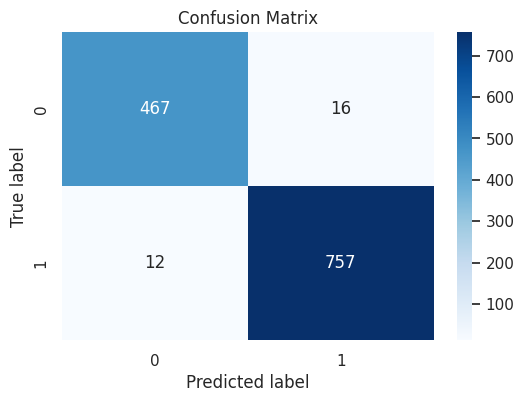

In [ ]:
# create a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')

# add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

From the confusion matrix:

The top left is True Negatives, these are the instances were the model correctly predicted negative for approvals: 467

The top right is is the False Positives, where the model incorrectly predicted the positive class: 16

The bottom left is the False Negatives, the model incorrectly predicted the negative class: 12

The bottom right is the True Positives, these are the cases where the model correctly predicted the positive class: 757

In [ ]:
# get feature importance
importance = forest_model.feature_importances_

# print important next to the column names
importance_series = pd.Series(importance, index=X_train.columns)
print(importance_series.sort_values(ascending=False))

loan_amount                 0.804784
income_annum                0.058466
self_employed               0.027836
loan_term                   0.019784
residential_assets_value    0.019182
education                   0.019123
cibil_score                 0.019101
commercial_assets_value     0.017414
no_of_dependents            0.008520
bank_asset_value            0.002939
luxury_assets_value         0.002852
dtype: float64


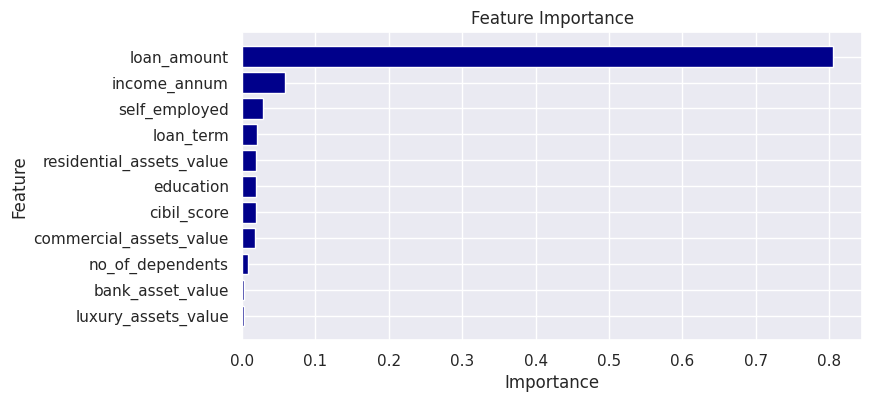

In [ ]:
# sort feature importances in descending order
sorted_importances = importance_series.sort_values(ascending=False)

# create a bar plot
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8,4))
plt.barh(sorted_importances.index, sorted_importances.values, color='darkblue')

# invert y-axis so that features with highest importance are at the top
plt.gca().invert_yaxis()

# add labels and title
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

Here we can see how important each feature is in determining the outcome of the predictions for the random forest model.

The Random Forest is an ensemble method that takes multiple decision trees and combines them for a more accurate and reliable prediction (Meltzer, 2023). This model achieved an AUC score of 0.9756, and an accuracy rate of 97.76%. A very useful benefit of this model is its ability to rank features by importance. Here, "loan amount" stood out as the most important feature, with a relative importance of 0.8, indicating its large influence in loan approval decisions. The next two most important features were "annual income" and the binary feature "self_employed".

## Stachastic Gradient Descent

In [ ]:
# create a stochastic gradient descent classifier
# use logistic regression as loss function
# L2, ridge regression, helps prevent overfitting by adding a penalty term
# optimal learning rate
# 1000 epochs or loop through the dataset 1000 times
sgd_model = SGDClassifier(loss='log', penalty='l2', learning_rate='optimal', max_iter=1000, random_state=1)

# train model with features and labels
sgd_model.fit(X_train_scaled, y_train)

# create predictions using test data
sgd_y_pred = sgd_model.predict(X_test_scaled)

# get the AUC score by comparing predictions to the actual test values
auc_score = roc_auc_score(y_test, sgd_y_pred)

# get the accuracy score by comparing predictions to the actual test values
accuracy = accuracy_score(y_test, sgd_y_pred)

print("AUC score:")
print(auc_score)

print("Accuracy score:")
print(accuracy)

AUC score:
0.9309675925551992
Accuracy score:
0.9289137380191693


Next, we used a Stochastic Gradient Descent (SGD), which is a linear model that is especially useful at handling large datasets by continuously updating its parameters based on the gradient of the loss function. Unlike traditional gradient descent that calculates the gradient using the entire dataset, the SGD estimates it using a single record at a time, which is both memory efficient and computationally faster (Price, 2020). For the parameters of the SGD, log loss was used as the function since this is a binary classification that penalizes false classifications. The L2 penalty, or Ridge regularization, was used to add a penalty and to help prevent overfitting by penalizing large coefficients. The model resulted in an AUC of 0.9309 and an accuracy rate of 92.89%. While less than the Random Forest, its simplicity and fast computing time could make it a preferred choice in cases where the data is extremely large or when there are limited computing resources.

## Neural Network

In [169]:
# create the keras model
nn_model = Sequential()

# adding a dense layer with 12 neurons and relu activation function, input_dim is the number of features in the input dataset
nn_model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))

# adding a second hidden layer with 8 neurons and relu activation function
nn_model.add(Dense(8, activation='relu'))

# adding the output layer with 1 neuron since it's a binary classification problem; sigmoid activation function outputs probabilities that sum to one
nn_model.add(Dense(1, activation='sigmoid'))

# compile the keras model
# compiling the model with binary crossentropy loss function for binary classification;
# adam optimizer is used for minimizing the loss function
# accuracy is chosen as a metric to evaluate the model's performance
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the model to the training data;
# using 10 epochs to iterate 10 times over the dataset during training,
# and batch_size of 10 means that the model is updated after 10 data points have been processed
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=10)

# create predictions using test data
y_pred = nn_model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)

# get the AUC score by comparing predictions to the actual test values
auc_score = roc_auc_score(y_test, y_pred)

# get the accuracy score by comparing predictions to the actual test values
accuracy = accuracy_score(y_test, y_pred)

print("AUC score:")
print(auc_score)

print("Accuracy score:")
print(accuracy)

Epoch 1/10
293/293 [==============================] - 1s 2ms/step - loss: 0.5600 - accuracy: 0.6891
Epoch 2/10
293/293 [==============================] - 1s 2ms/step - loss: 0.3274 - accuracy: 0.8785
Epoch 3/10
293/293 [==============================] - 1s 2ms/step - loss: 0.2334 - accuracy: 0.9127
Epoch 4/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1991 - accuracy: 0.9230
Epoch 5/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1809 - accuracy: 0.9308
Epoch 6/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1691 - accuracy: 0.9391
Epoch 7/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.9442
Epoch 8/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1510 - accuracy: 0.9466
Epoch 9/10
293/293 [==============================] - 1s 2ms/step - loss: 0.1451 - accuracy: 0.9517
Epoch 10/10
40/40 [==============================] - 0s 2ms/step
AUC score:
0.9348001087696909
Accur

For our final model, we created a neural network using Keras. This model was built with an input layer that matches the number of features in our dataset. Next, two hidden layers were added: the first with 12 neurons and the second with 8, both using the RELU activation function. The final layer is a single neuron and a sigmoid activation function, which outputs the probability of loan approval. During the compilation phase, the model also uses the 'adam' optimizer and 'binary cross entropy' as the loss function, which is suited for binary classification tasks like our own (Tanwar, 2022). The model was trained in 10 epochs with batches of 10 records at a time. This final model results in an AUC score of 0.9348 and an accuracy score of 93.93%, still slightly outperformed by the Random Forest.

## Hyperparameter tuning with GridSearchCV

In [163]:
# set the models and their parameters to loop over
models = [
    ('Random Forest', RandomForestClassifier(random_state=42), X_train_scaled, X_test_scaled, {
        'n_estimators': [5, 50, 100, 500, 1000],
        'max_depth': [None, 5, 10, 15, 20, 50],
    }),
    ('SGD', SGDClassifier(random_state=42), X_train_scaled, X_test_scaled, {
        'loss': ['log'],
        'penalty': ['l2', 'l1'],
        'learning_rate': ['optimal'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
    })
]

# store the best models and their scores
best_models = {}
best_scores = {}
best_params = {}

For the parameters of:

Random Forest:


*  estimators: number of trees in the forest, more can be more accuracy but requires more computation and possible overfitting
*   depth: same as decision trees.

SGD:

*   loss: defines the loss function to be minimized during the optimization. In this case, 'log' is used for logistic regression, making the SGD classifier for binary.
*   penalty: sets the the penalization for 'l2' and 'l1'. L1 pushes less important features coefficients to zero, creating feature selection, while L2 shrinks the less important features towards zero but doesn't remove them.
*   learning rate: controls the step size at each iteration while moving toward a minimum of the loss function.
*   alpha: the amount of regularization applied, with larger values meaning more regularization.

In [164]:
# perform Grid Search for each model, use x train and x test
# use 5 fold cross validation and then test on each generated y_train
for name, model, X_train, X_test, params in models:
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # store the best model, score, and parameters
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    best_params[name] = grid_search.best_params_

In [165]:
# print the best models, scores, and parameters for each
for name in best_models:
    print(f"Best {name} model: {best_models[name]}")
    print(f"Best accuracy score: {best_scores[name]}")
    print(f"Best parameters: {best_params[name]}\n")

Best Random Forest model: RandomForestClassifier(n_estimators=1000, random_state=42)
Best accuracy score: 0.979458494321508
Best parameters: {'max_depth': None, 'n_estimators': 1000}

Best SGD model: SGDClassifier(alpha=0.001, loss='log', random_state=42)
Best accuracy score: 0.9277689966046131
Best parameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l2'}



Finally, we also used GridSearchCV on the Random Forest and SGD models, to find the optimal parameters that resulted in the highest accuracy. Due to computational constraints, our neural network wasn't part of this grid search. The Random Forest model outperforms the SGD model in terms of accuracy with the given dataset and parameter range explored. It achieves an accuracy of about 97.95% compared to the 92.78% of the SGD model. The best parameters for this was a max depth of 20 and using 1000 trees or estimators.

## Model Comparison

Text(0.5, 1.0, 'Cumulative Gains Chart - Validation Data Results')

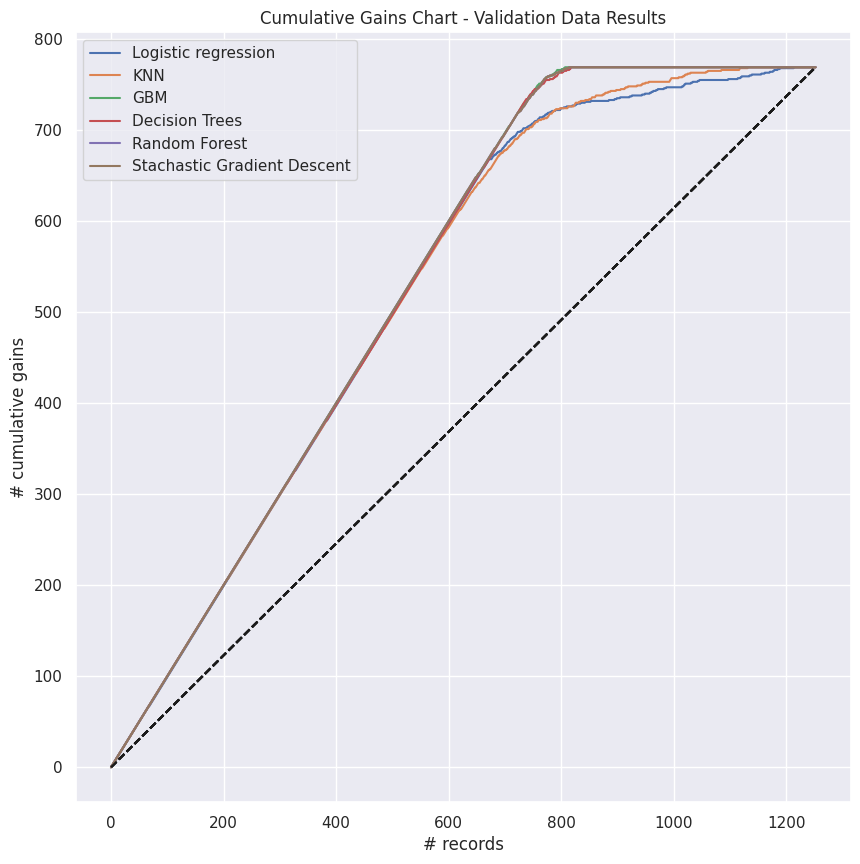

In [173]:
# Logistic regression

lg_proba =  logit.predict_proba(X_test_scaled)
lg_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in lg_proba],
                            'p(1)': [p[1] for p in lg_proba],
                            'predicted': logit.predict(X_test_scaled),
                          })
lg_result = lg_result.sort_values(by=['p(1)'], ascending=False)

# KNN

knn_tree_proba = knn.predict_proba(X_test_scaled)
knn_tree_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in knn_tree_proba],
                            'p(1)': [p[1] for p in knn_tree_proba],
                            'predicted': knn.predict(X_test_scaled),
                          })
knn_tree_result = knn_tree_result.sort_values(by=['p(1)'], ascending=False)

# Gradient Boosting

gbm_proba = boost.predict_proba(X_test_scaled)
gbm_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in gbm_proba],
                            'p(1)': [p[1] for p in gbm_proba],
                            'predicted': boost.predict(X_test_scaled),
                          })
gbm_result = gbm_result.sort_values(by=['p(1)'], ascending=False)

# Decision Trees

dec_tree_proba = gridSearch.best_estimator_.predict_proba(X_test_scaled)
dec_tree_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in dec_tree_proba],
                            'p(1)': [p[1] for p in dec_tree_proba],
                            'predicted': gridSearch.best_estimator_.predict(X_test_scaled),
                          })
dec_tree_result = dec_tree_result.sort_values(by=['p(1)'], ascending=False)

# Random Forest

rf_proba =  forest_model.predict_proba(X_test_scaled)
rf_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in rf_proba],
                            'p(1)': [p[1] for p in rf_proba],
                            'predicted': forest_model.predict(X_test_scaled),
                          })
rf_result = rf_result.sort_values(by=['p(1)'], ascending=False)

# Stachastic Gradient Descent

sgd_proba = sgd_model.predict_proba(X_test_scaled)
sgd_result = pd.DataFrame({'actual': y_test.astype("int64"),
                            'p(0)': [p[0] for p in sgd_proba],
                            'p(1)': [p[1] for p in sgd_proba],
                            'predicted': sgd_model.predict(X_test_scaled),
                          })
sgd_result = sgd_result.sort_values(by=['p(1)'], ascending=False)



ax = gainsChart(lg_result.actual, label='Logistic regression', color='C0', figsize=[10, 10])
ax = gainsChart(knn_tree_result.actual, label='KNN', color='C1', ax=ax)
ax = gainsChart(gbm_result.actual, label='GBM', color='C2', ax=ax)
ax = gainsChart(dec_tree_result.actual, label='Decision Trees', color='C3', ax=ax)
ax = gainsChart(rf_result.actual, label='Random Forest', color='C4', ax=ax)
ax = gainsChart(rf_result.actual, label='Stachastic Gradient Descent', color='C5', ax=ax)

ax.legend()
ax.set_title('Cumulative Gains Chart - Validation Data Results')

Decision Tree model demonstrates excellent performance with a high accuracy of 97.84% on the validation set, alongside impressive precision, recall, and F1-score metrics. It maintains strong generalization capabilities, and the negative AIC value suggests a solid model fit. These results indicate that the Decision Tree is both effective and reliable for our project. Additionally, the model can be fine-tuned to balance between depth and simplicity to avoid overfitting, ensuring consistent and dependable performance across diverse datasets.

## Results, Discussion and Conclusion

The model with the highest accuracy was the decision tree, with an accuracy of 97.44%, precision of 97.67%, recall of 98.18% and an F1-score of 97.92%. This implies that tree-based models, such as the Random Forest and the Decision Tree, were the best models, in terms of accuracy for predicting loan approvals based on the given features. The Random Forest's results show how powerful ensemble models can be in finding patterns in datasets with many different features and relationships such as ours. The logistic regression models, KNN model and gradient boosting models also had impressive accuracy and could be preferred models due to their simplicity and ease of explainability in results. On the other hand, while the Neural Network's high accuracy also displays the flexibility and potential of deep learning models, results and predictions can be difficult to explain and interpret, which could be very important whether in explaining results to customers or management . It should also be noted that, at an accuracy that's not too far off, the SGD model could also be a preferred choice when the data is extremely large or if there are limited computing resources.

Machine learning can create new innovations and transformations for financial institutions, especially banks, to update their traditional loan approval processes. Traditional methods are often time-consuming and can be prone to human biases and overlook data patterns that algorithms can accurately find (Roth, 2023). Automating the loan approval process through exploratory data analysis and predictive models, such as the ones created in this project, not only makes this decision-making process faster, leading to cost savings and higher customer satisfaction, but can also lead to lower risk of loans and higher likelihood of returns from the borrowers.

The high accuracy of these models can ensure a very detailed risk assessment of every loan. By finding these hidden patterns in applicant data, banks can make more informed lending decisions and can discern between higher and lower risk individuals. This accuracy can reduce the likelihood of defaults and can create a higher return on investment. In summary, implementing machine learning into the traditional loan approval process can lead to faster decision making, higher efficiency, lower risk, and increased profitability for institutions such as banks.